# TP2 Regression Linéaire


## Exercice 1 Analyse de la base de données “investment data”

## Cas p=1

### 1) Affichage des 5 premières observations de la table

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import t
import math
from sklearn.metrics import mean_squared_error

df= pd.read_csv("https://bitbucket.org/portierf/shared_files/downloads/invest.txt", " ")
df.head(5)



,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


### 2) Passer GNP en log (insertion d'une colonne)

In [2]:
#Ajout d'une colonne de log(gnp)
df["loggnp"]=np.log(df["gnp"])
df["invest"]=np.log(df["invest"])

df.head()


,year,gnp,invest,cpi,interest,loggnp
0,1968,873.4,4.892602,82.54,5.16,6.772394
1,1969,944.0,5.005958,86.79,5.87,6.850126
2,1970,992.7,4.971201,91.45,5.95,6.900429
3,1971,1077.6,5.114395,96.01,4.88,6.982492
4,1972,1185.9,5.273000,100.00,4.50,7.078257


### Plot de log(Invest) en fonction de log(GNP)

<IPython.core.display.Javascript object>


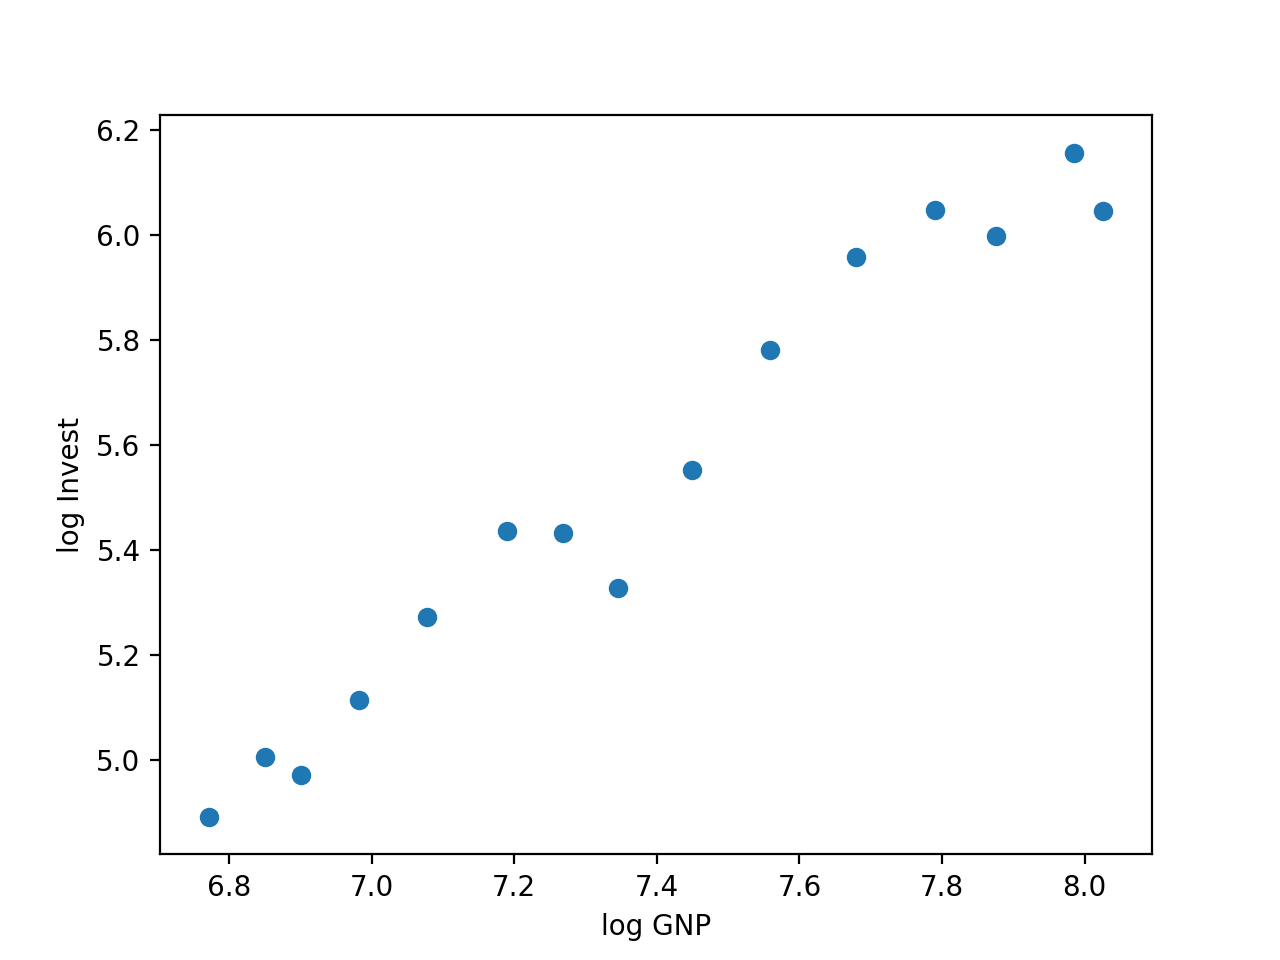

In [3]:
plt.figure()
plt.scatter(df["loggnp"], df["invest"])
plt.xlabel("log GNP")
plt.ylabel("log Invest")
plt.show()

### 3) Estimer les coefficients de regression

In [4]:
X= df["loggnp"].values

# Nombre d'échantillons
n= len(X)

X=X.reshape((n,1))
Y= df["invest"].values.reshape(n,1)
meanx= X.mean()
meany= Y.mean()

#On calcule B1 par la division de deux sommes (d'après exercice 12)
sumtop= 0
sumbottom= 0

for i in range(0,n) :
    sumtop+=(X[i]-meanx)* (Y[i]-meany)
    sumbottom+=(X[i]-meanx)**2

B1= sumtop/sumbottom
# puis B0
B0= meany-B1*meanx
print(f"Coefficient B0 : {round(B0[0],2)} ")
print(f"Coefficient B1 : {round(B1[0],2)} ")


Coefficient B0 : -1.96 
Coefficient B1 : 1.02 


### Calculer l'écart type des coefficients

In [5]:
#On calcule la variance de l'estimateur
variance_estimateur=0
for i in range(0,n) :
    variance_estimateur+=(Y[i]-B0-B1*X[i])**2
variance_estimateur = variance_estimateur/(n-2)

#Calcul intermédiaire utile pour le calcul des écarts type
bottomB= sum([(xi-meanx)**2 for xi in X])

B0ecartype= math.sqrt(variance_estimateur*(1/n+meanx**2/bottomB)) 
B1ecarttype= math.sqrt(variance_estimateur/bottomB)
print(f"Variance : {round(variance_estimateur[0],4)} ")
print(f"Ecart type de B0 : {round(B0ecartype,4)} ")
print(f"Ecart type de B1 : {round(B1ecarttype,4)} ")

Variance : 0.0077 
Ecart type de B0 : 0.4095 
Ecart type de B1 : 0.0554 


### Coefficient de détermination

In [6]:
SST = sum([(yi - meany)**2 for yi in Y])
SSReg = sum([(B0+B1*xi - meany)**2 for xi in X])
Rsquared = SSReg/SST
print(f"Coefficient de détermination : {round(Rsquared[0],3)} ")

Coefficient de détermination : 0.963 


### Plot de la regression linéaire 

<IPython.core.display.Javascript object>


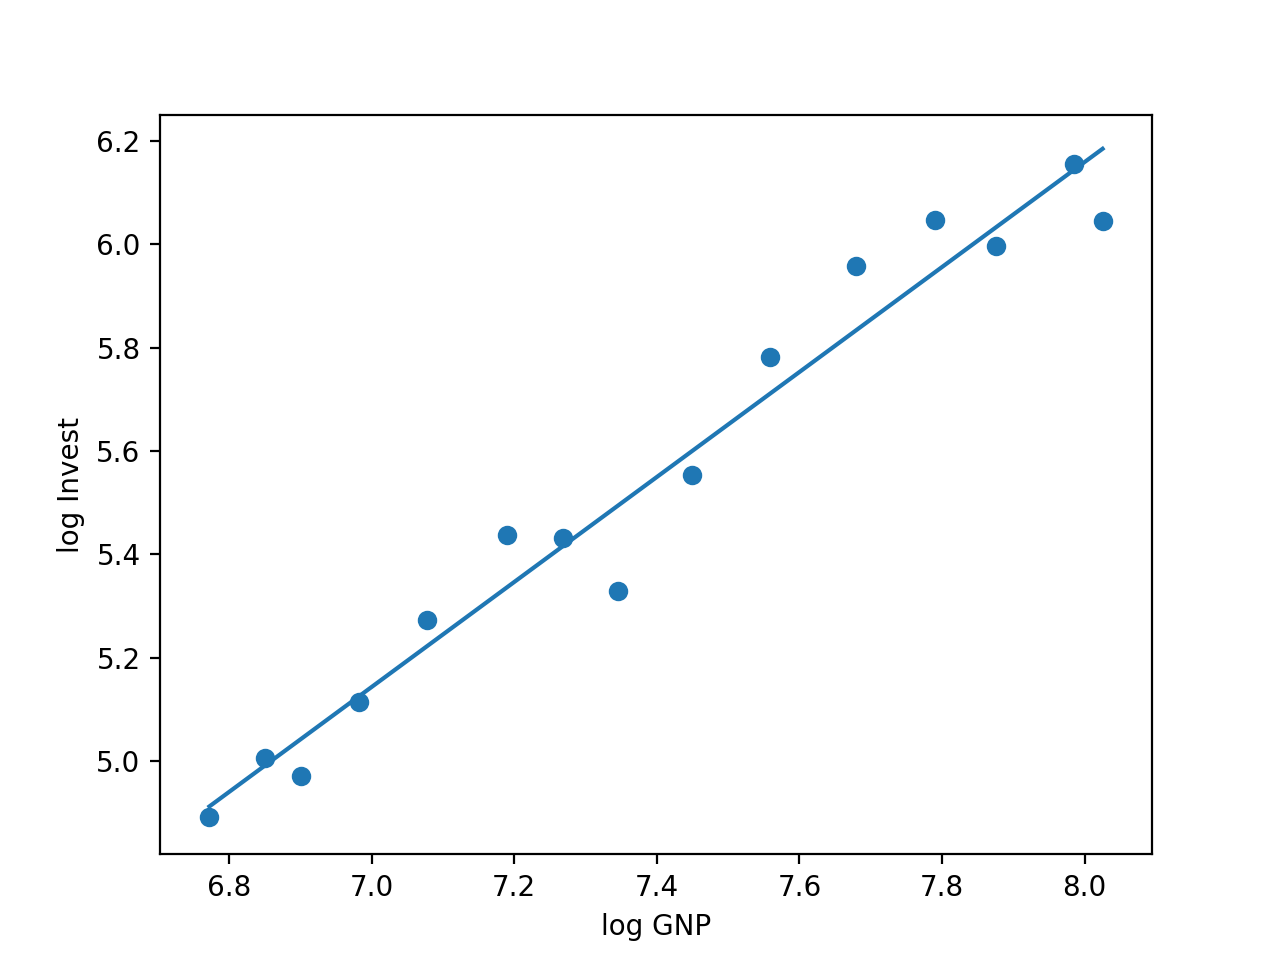

In [7]:
plt.figure()
plt.scatter(X, Y)
plt.plot(X,B0+B1*X, label="Regression")
plt.xlabel("log GNP")
plt.ylabel("log Invest")
plt.show()

### 4) Test de student sur  B1

In [8]:
# D'apres la formule dans l'exercice 12 la t-stat est définie par
tstat=B1/B1ecarttype
print(f"Tstat : {round(tstat[0],4)} ")

#on calcule la pval correspondante à notre T-stat 
degreefreedom=n-2
pval= (t.sf(abs(tstat), degreefreedom)) * 2
print(f"pval : {round(pval[0],10)} ")


Tstat : 18.332 
pval : 1e-10 


On rejette l'hypothese H0 selon laquelle B1=0 avec un pourcentage de se tromper inférieur à alpha=0.01 (rejet à tort).

La pente estimée est donc statistiquement significative

### 5) Prédiction d'une nouvelle valeur

In [9]:
xnew= np.array([[1],[np.log(1000)]], ndmin=2)
B=np.array([[B0[0]],[B1[0]]])
print(B)
ynew=xnew.transpose().dot(B)
# On applique exp pour avoir la vraie valeur de y 

ynewReel=np.exp(ynew[0][0])
print(f"Estimation de Investment pour GNP=1000 : {round(ynewReel, 2)}")


[[-1.96359134]
 [ 1.0152814 ]]
Estimation de Investment pour GNP=1000 : 155.98


### Intervalles de confiance pour Ypred et Y

Pour cela on utilise la formule du poly pour les CI et PI

In [10]:
alpha= 0.1
#On calcule le quantile de student correspondant à notre alpha 
q=t.ppf(1-alpha/2,df=degreefreedom)

#On ajoute la colonne de l'intercept 
Xintercept = np.append(np.ones((n,1)), X.reshape((n,1)), axis=1)
#Calcul de la matrice de gram puis son inverse
gram=Xintercept.transpose().dot(Xintercept)
graminv=np.linalg.inv(gram)

vec=xnew.transpose().dot(graminv).dot(xnew)

CIlog=[ ynew-q*np.sqrt(variance_estimateur*vec) , ynew+q*np.sqrt(variance_estimateur*vec) ]
CI= np.exp(CIlog)

PIlog=[ ynew-q*np.sqrt(variance_estimateur*(1+vec)) , ynew+q*np.sqrt(variance_estimateur*(1+vec)) ]
PI=np.exp(PIlog)

print(f"Intervalle de confiance pour la log(prediction) : {round(CIlog[0][0][0], 3), round(CIlog[1][0][0], 3)}")
print(f"Intervalle de confiance pour la prediction : {round(CI[0][0][0], 2), round(CI[1][0][0], 2)}")
print(f"Intervalle de confiance pour le nouvel y : {round(PIlog[0][0][0], 3), round(PIlog[1][0][0], 3)}")
print(f"Intervalle de confiance pour le nouvel y : {round(PI[0][0][0], 2), round(PI[1][0][0], 2)}")

Intervalle de confiance pour la log(prediction) : (4.988, 5.111)
Intervalle de confiance pour la prediction : (146.68, 165.87)
Intervalle de confiance pour le nouvel y : (4.883, 5.217)
Intervalle de confiance pour le nouvel y : (132.0, 184.31)


Ceci est vrai pour alpha= 0.1

### 6) Tracer la droite de regression et les CI et PI

<IPython.core.display.Javascript object>


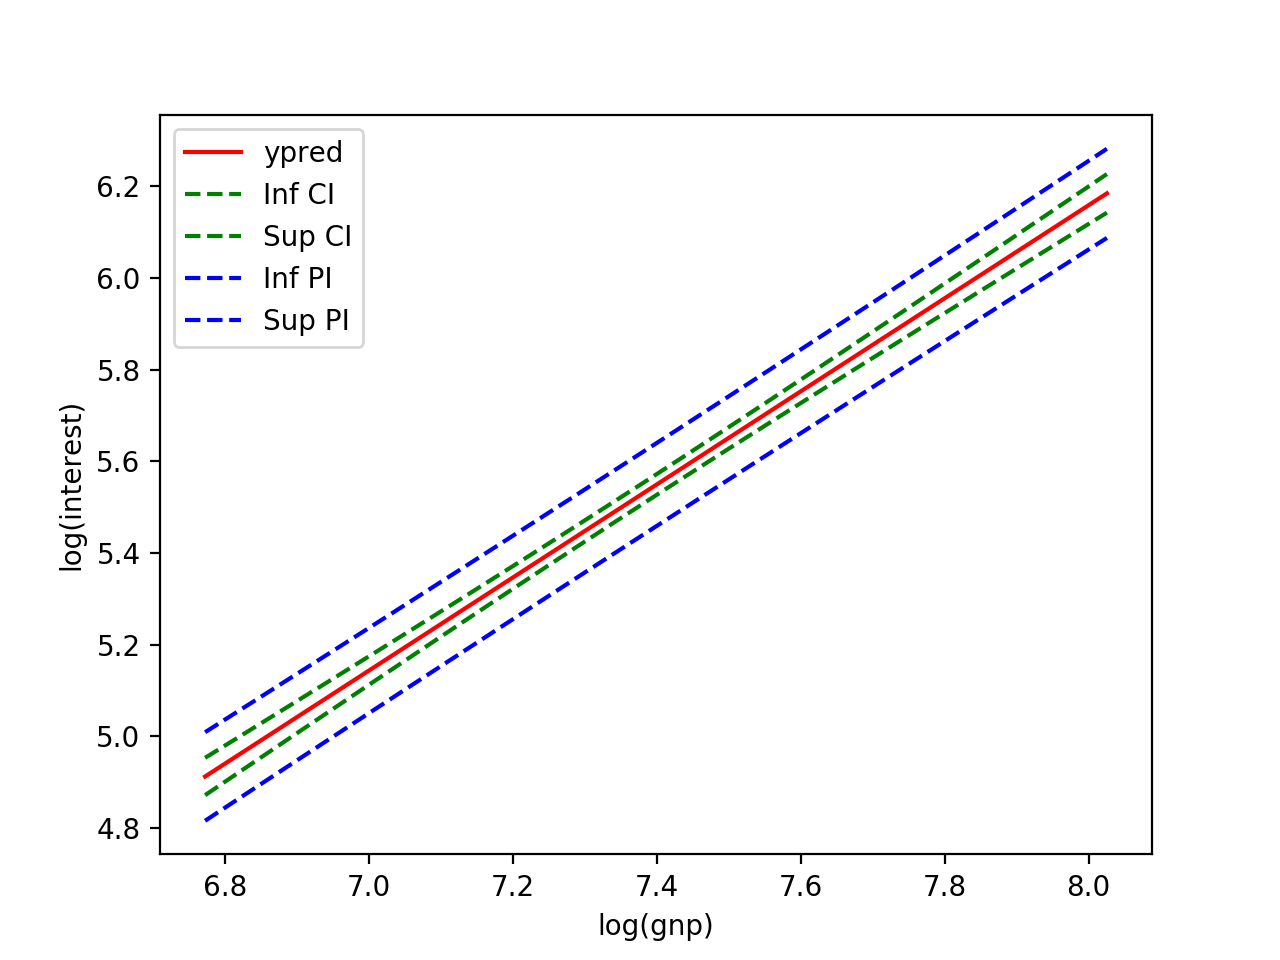

In [11]:
#On veut un ensemble de valeur de x pour tracer y pred , les CI et PI
xlinspace = np.linspace(X.min(), X.max())
xlinspaceIntercept= np.append(np.ones((len(xlinspace),1)), xlinspace.reshape((len(xlinspace),1)), axis=1)
ypredlinspace= np.array([ B.transpose()@x for x in xlinspaceIntercept])

# Definition de fonctions pour estimer les intervalles de confiance 
def confmin(x, y, graminv, variance):
    return y - math.sqrt(variance*x.dot(graminv).dot(x.transpose()))
def confmax(x, y, graminv, variance):
    return y + math.sqrt(variance*x.dot(graminv).dot(x.transpose()))
def confPmin(x, y, graminv, variance):
    return y - math.sqrt(variance*(1+x.dot(graminv).dot(x.transpose())))
def confPmax(x, y, graminv, variance):
    return y + math.sqrt(variance*(1+x.dot(graminv).dot(x.transpose())))

y_inf = [confmin(xi, y, graminv, variance_estimateur) for (xi,y) in zip(xlinspaceIntercept,ypredlinspace)]
y_sup = [confmax(xi, y, graminv, variance_estimateur) for (xi,y) in zip(xlinspaceIntercept,ypredlinspace)]
y_pinf = [confPmin(xi, y, graminv, variance_estimateur) for (xi,y) in zip(xlinspaceIntercept,ypredlinspace)]
y_psup = [confPmax(xi, y, graminv, variance_estimateur) for (xi,y) in zip(xlinspaceIntercept,ypredlinspace)]


plt.figure()
plt.plot(xlinspace,ypredlinspace,'r',label='ypred')
plt.plot(xlinspace,y_inf,'g--',label='Inf CI')
plt.plot(xlinspace,y_sup,'g--',label='Sup CI')
plt.plot(xlinspace,y_pinf,'b--',label='Inf PI')
plt.plot(xlinspace,y_psup,'b--',label='Sup PI')
plt.xlabel("log(gnp)")
plt.ylabel("log(interest)")
plt.legend()
plt.show()



### 7) Utiliser les librairies pour entrainer un modèle et comparer les résultats

In [12]:
# CHoix de sklearn
reg = LinearRegression()
regr = reg.fit(X, Y)
Y_pred = regr.predict(X)
mse = mean_squared_error(Y, Y_pred)
rmse = np.sqrt(mse)
r2_score = reg.score(X, Y)
prediction_new = reg.predict(np.log(1000))[0]



print(f"Coefficients B0 : {round(reg.intercept_[0], 4)}")
print(f"Coefficients B1 : {round(reg.coef_[0][0], 4)}")
print(f"R2 Score : {round(r2_score, 4)}")
print(f"Prédiction pour le nouvel y : {round(prediction_new[0], 4)}")


Coefficients B0 : -1.9636
Coefficients B1 : 1.0153
R2 Score : 0.9628
Prédiction pour le nouvel y : 5.0497


On en déduit que les valeurs sont les mêmes.

### 8) Plot de la regression par scikit learn avec la nouvelle prédiction

<IPython.core.display.Javascript object>


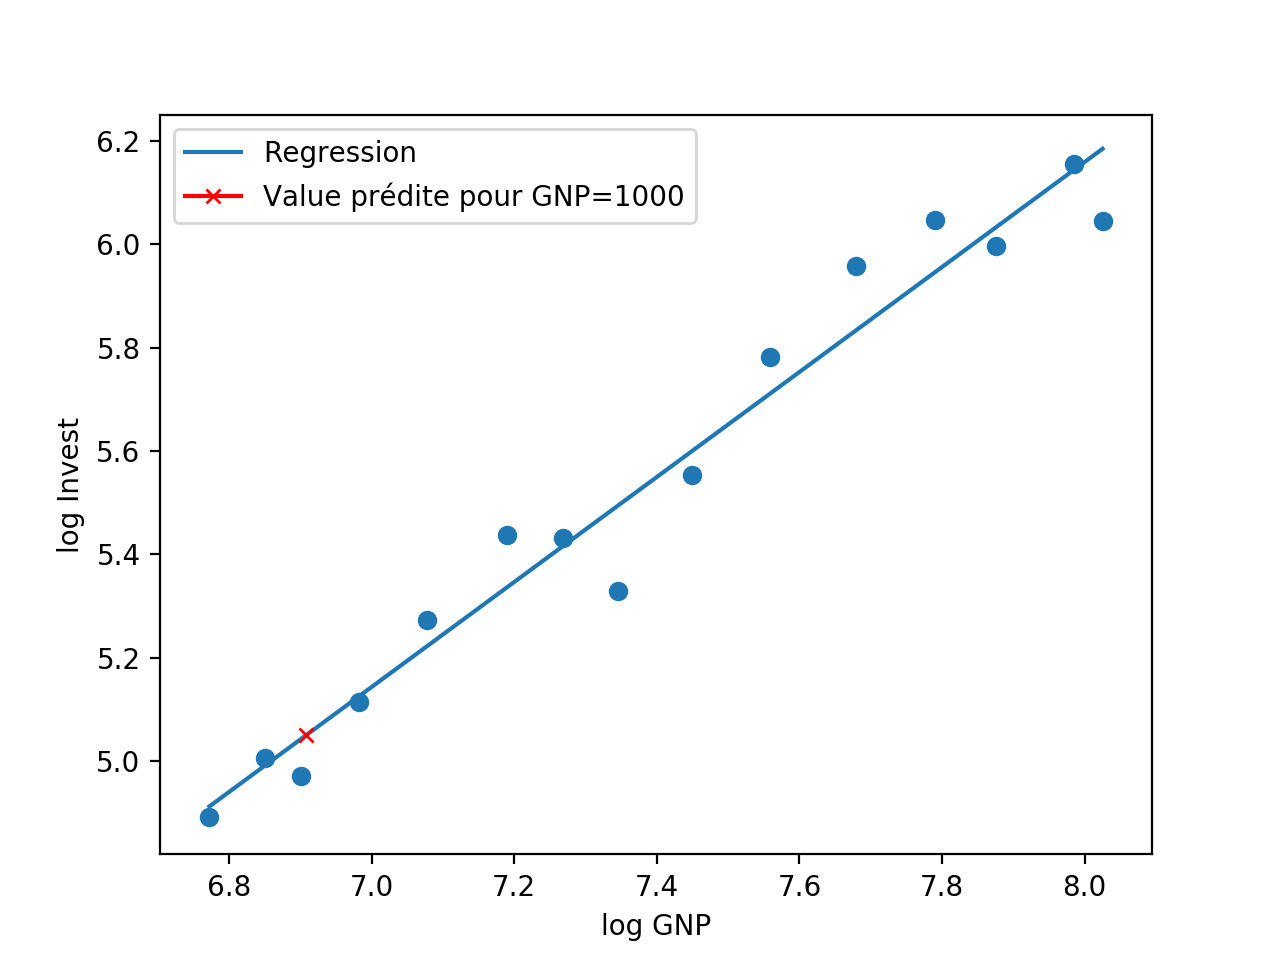

In [13]:
plt.figure()
plt.scatter(X, Y)
plt.plot(X,reg.intercept_+reg.coef_*X, label="Regression")
plt.xlabel("log GNP")
plt.ylabel("log Invest")

plt.plot(xnew[1], prediction_new, marker='x', markersize=5, color="red", label="Value prédite pour GNP=1000")
plt.legend(loc='best')
plt.show()



## Cas p = 2
On s'intéresse maintenant à la regression linéaire à deux variables

### 9) Regression linéaire multiple

In [14]:
#Rédéfinition de notre matrice X
Xmulti= np.array([df["loggnp"], df["interest"]]).transpose()
XmultiIntercept=np.append(np.ones((n,1)), Xmulti, axis=1)

In [28]:
#Redéfinition de notre matrice de gram 
gramMulti=XmultiIntercept.transpose().dot(XmultiIntercept)
print(f"Le rang de la matrice de gram est  : {np.linalg.matrix_rank(gramMulti)}")
print(np.linalg.eig(gramMulti))


Le rang de la matrice de gram est  : 3
(array([1.73787190e+03, 1.82369697e-02, 4.12140362e+01]), array([[ 0.09091344,  0.98829863, -0.12247679],
       [ 0.67802329, -0.15150652, -0.71925669],
       [ 0.72939644,  0.01765201,  0.68386347]]))


On en déduit qu'on peut la matrice est de rang plein donc inversible

#### On recalcule les coefficients

In [16]:
#Redéfinition de nos coefficients
Bmulti= np.linalg.inv(gramMulti).dot(XmultiIntercept.transpose().dot(Y))

In [17]:
# recalcul de la Variance de l'estimateur
varianceEstimateurMulti=0
for i in range(0,n) :
    varianceEstimateurMulti+=(Y[i]-XmultiIntercept[i].dot(Bmulti))**2
varianceEstimateurMulti = varianceEstimateurMulti/(n-3)
print(f"Le variance de l'estimateur est  : {round(varianceEstimateurMulti[0], 5)}")

Le variance de l'estimateur est  : 0.00819


#### On calcule l'écart type des coefficients, cette fois sans la formule de l'exercice 2 (en dim 1) mais grace à cette formule (stack) on peut trouver l'écart type.

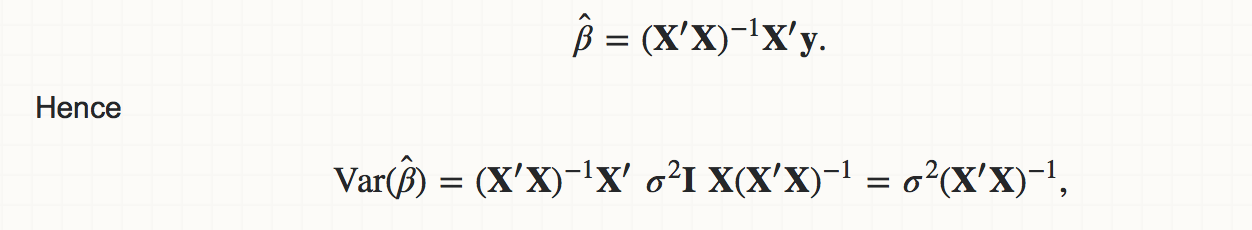

La variance de chacun des coefficient est donc sur la diagonale de la matrice de covariance

In [18]:

varianceB=varianceEstimateurMulti*np.diag(np.linalg.inv(gramMulti))
seB=np.sqrt(varianceB)
print(f"L'écart type des coefficients pour B0, B1, B2 est  : {seB}")

L'écart type des coefficients pour B0, B1, B2 est  : [0.6623992  0.10206138 0.01534421]


In [19]:
SSReg = sum([(xi.dot(Bmulti) - meany)**2 for xi in XmultiIntercept])
Rsquared = SSReg/SST
print(f"Le coefficient de détermination devient {Rsquared}")

Le coefficient de détermination devient [0.96331083]


On fait un test de student sur nos coefficients pour déterminer leur significativité. 
On calcule donc les t stats puis les p values

In [20]:
tstatmultiB1=Bmulti[1]/seB[1]
tstatmultiB2=Bmulti[2]/seB[2]
print(f"La Tstat pour B1 :  {tstatmultiB1}")
print(f"La Tstat pour B2 :  {tstatmultiB2}")

La Tstat pour B1 :  [10.30010285]
La Tstat pour B2 :  [-0.4254948]


In [21]:
pval1= (t.sf(abs(tstatmultiB1), n-3)) * 2
pval2= (t.sf(abs(tstatmultiB2), n-3)) * 2
print(f"La pvalue pour B1 :  {pval1}")
print(f"La pvalue pour B2 :  {pval2}")

La pvalue pour B1 :  [2.59951685e-07]
La pvalue pour B2 :  [0.67800714]


On peut dire que  B1 reste significatif (pvalue <<alpha=0.01) , on a peu de chance de rejeter l'hypothese B1=0
Pour B2, on a 67 % de chance de rejeter à tort l'hypothèse B2=0, on ne la rejette donc pas et on peut dire que B2 n'est pas statistiquement significatif

### 11) Prédiction avec le nouveau modèle pour GNP=1000

In [22]:
ypredMulti= XmultiIntercept.dot(Bmulti)
xnewMulti= np.array([[1, np.log(1000), 10]]).transpose()
ynewpredMulti= xnewMulti.transpose().dot(Bmulti)
print(f"La valeur prédite pour GNP= 1000 dans le nouveau modèle est :  {ynewpredMulti}")

La valeur prédite pour GNP= 1000 dans le nouveau modèle est :  [[5.01598373]]


#### On s'intéresse aux intervalles de confiances de y et de l'estimateur de y

In [23]:
alpha= 0.001
q=t.ppf(1-alpha/2,df=12)
#On inverse la matrice de gram
graminvMulti=np.linalg.inv(gramMulti)
vec=xnewMulti.transpose().dot(graminvMulti).dot(xnewMulti)
# D'après les formules du cours pour les intervalles de confiance
CIlog=[ ynewpredMulti-q*np.sqrt(varianceEstimateurMulti*vec), ynewpredMulti+q*np.sqrt(varianceEstimateurMulti*vec)]
CI=np.exp(CIlog)
PIlog=[ ynewpredMulti-q*np.sqrt(varianceEstimateurMulti*(1+vec)) , ynewpredMulti+q*np.sqrt(varianceEstimateurMulti*(1+vec))]
PI=np.exp(PIlog)

print(f"Intervalle de confiance pour la log(prediction) : {round(CIlog[0][0][0], 3), round(CIlog[1][0][0], 3)}")
print(f"Intervalle de confiance pour la prediction : {round(CI[0][0][0], 2), round(CI[1][0][0], 2)}")
print(f"Intervalle de confiance pour le nouvel y : {round(PIlog[0][0][0], 3), round(PIlog[1][0][0], 3)}")
print(f"Intervalle de confiance pour le nouvel y : {round(PI[0][0][0], 2), round(PI[1][0][0], 2)}")

Intervalle de confiance pour la log(prediction) : (4.64, 5.392)
Intervalle de confiance pour la prediction : (103.56, 219.59)
Intervalle de confiance pour le nouvel y : (4.474, 5.558)
Intervalle de confiance pour le nouvel y : (87.69, 259.35)


### 12) Plot de la régression + intervalles de confiance

In [24]:
Xgrid, Ygrid = np.meshgrid(XmultiIntercept[:,1], XmultiIntercept[:,2])
#Définition des fonctions qui vont permettre le calcul des intervalles de confiance et de la ypred

def confCIInf(x1, x2):
    xvec=np.array([1,x1,x2])
    dist=q*math.sqrt(varianceEstimateurMulti*xvec.transpose().dot(graminvMulti).dot(xvec))
    return Bmulti.transpose().dot(xvec) - dist
def confCISup(x1, x2):
    xvec=np.array([1,x1,x2])
    dist=q*math.sqrt(varianceEstimateurMulti*xvec.transpose().dot(graminvMulti).dot(xvec))
    return Bmulti.transpose().dot(xvec) + dist
def confPIInf(x1, x2):
    xvec=np.array([1,x1,x2])
    dist=q*math.sqrt(varianceEstimateurMulti*(1+xvec.transpose().dot(graminvMulti).dot(xvec)))
    return Bmulti.transpose().dot(xvec) - dist
def confPISup(x1, x2):
    xvec=np.array([1,x1,x2])
    dist=q*math.sqrt(varianceEstimateurMulti*(1+xvec.transpose().dot(graminvMulti).dot(xvec)))
    return Bmulti.transpose().dot(xvec) + dist
def Ypred(x1, x2):
    xvec=np.array([1,x1,x2])
    return Bmulti.transpose().dot(xvec) 

#on prend des points répartis sur x1 puis sur x2 pour avoir une grille de valeur 
x1 = np.linspace(df["loggnp"].min(), df["loggnp"].max())
x2 = np.linspace(df["interest"].min(), df["interest"].max())
Z_inf=[[confCIInf(x1_,x2_) for x1_ in x1] for x2_ in x2]
Z_sup=[[confCISup(x1_,x2_) for x1_ in x1] for x2_ in x2]
ZP_inf=[[confPIInf(x1_,x2_) for x1_ in x1] for x2_ in x2]
ZP_sup=[[confPISup(x1_,x2_) for x1_ in x1] for x2_ in x2]
ypredmulti3D=[[Ypred(x1_,x2_) for x1_ in x1] for x2_ in x2]

<IPython.core.display.Javascript object>


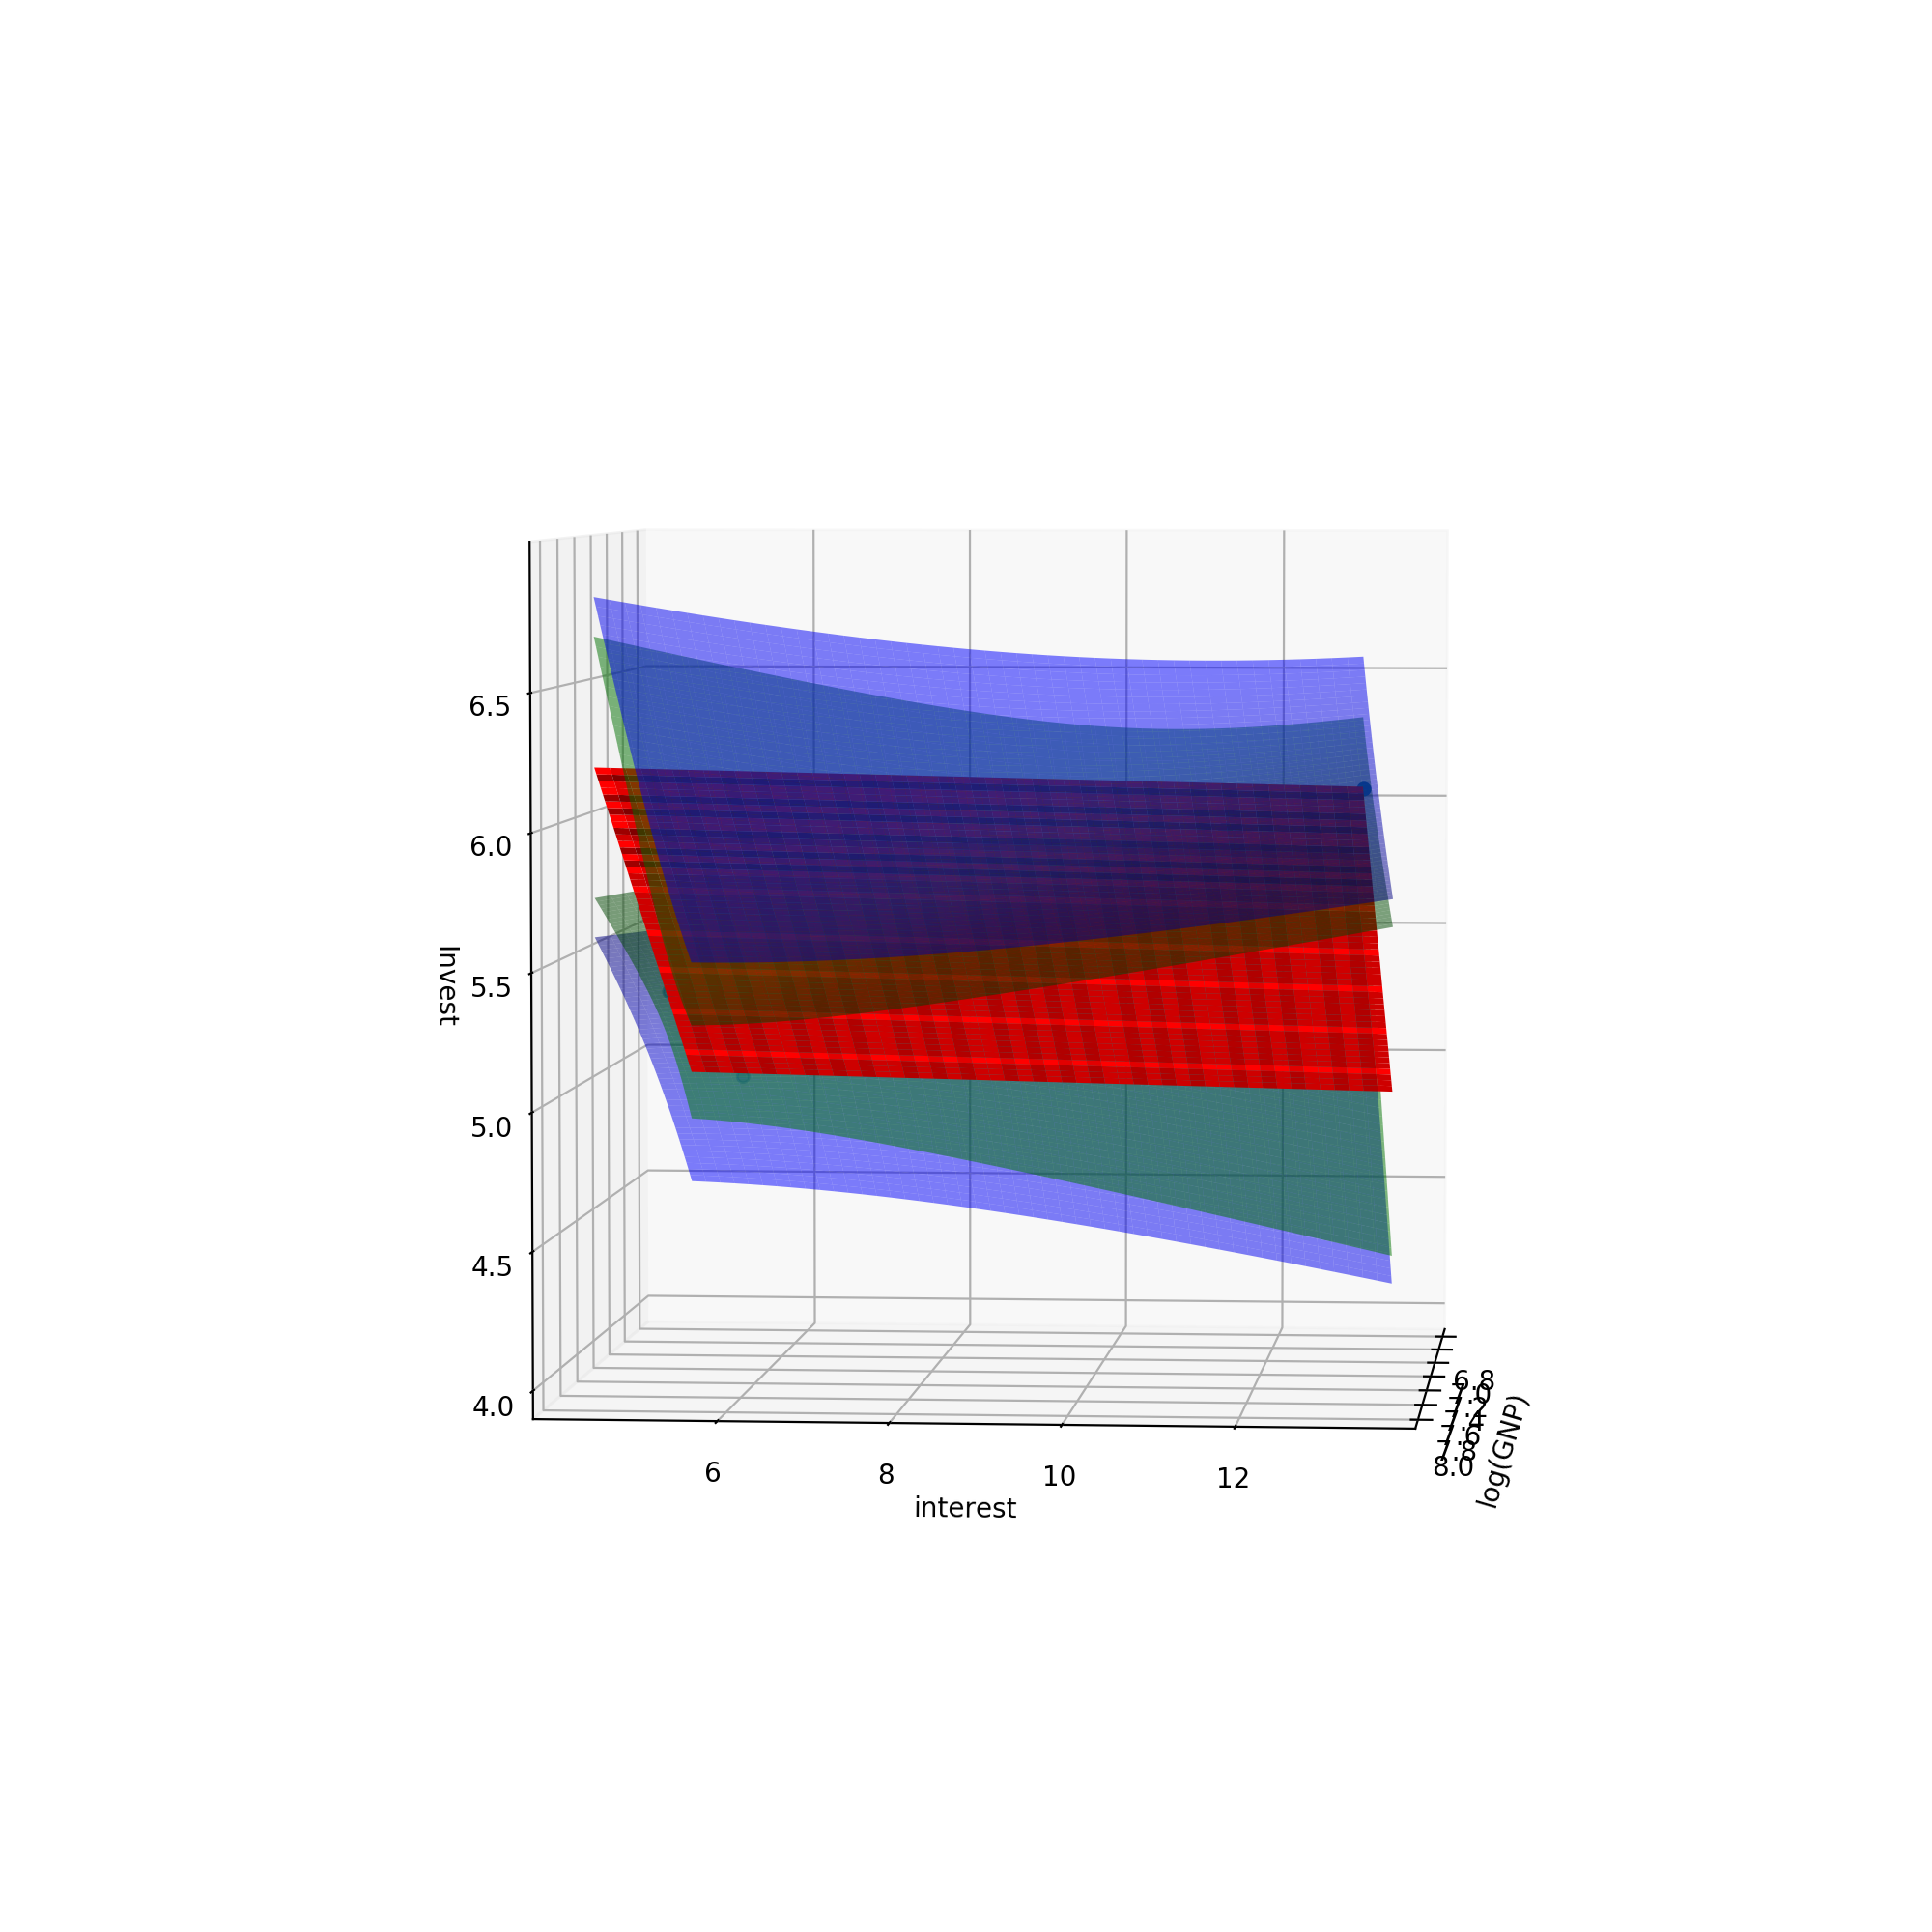

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
Xgrid, Ygrid = np.meshgrid(XmultiIntercept[:,1], XmultiIntercept[:,2])

X1,X2 = np.meshgrid(x1,x2)

ax.plot_surface(X1, X2, np.array(Z_inf).reshape(50,50), alpha=0.5, color="green")
ax.plot_surface(X1, X2, np.array(Z_sup).reshape(50,50), alpha=0.5, color="green")
ax.plot_surface(X1, X2, np.array(ZP_inf).reshape(50,50), alpha=0.5, color="blue")
ax.plot_surface(X1, X2, np.array(ZP_sup).reshape(50,50), alpha=0.5, color="blue")

ax.plot_surface(X1, X2,np.array(ypredmulti3D).reshape(50,50), color="red")
ax.scatter3D(XmultiIntercept[:,1], XmultiIntercept[:,2], df["invest"], cmap='Greens');


ax.view_init(30, 60)

ax.set_xlabel('log(GNP)')
ax.set_ylabel('interest')
ax.set_zlabel('Invest')

plt.show()

### 13) Refaire la régression avec les librairies

In [26]:
from scipy import stats
# Creating Model
reg = LinearRegression()
reg = reg.fit(Xmulti, Y)
Y_pred = reg.predict(Xmulti)
mse = mean_squared_error(Y, Y_pred)
rmse = np.sqrt(mse)
r2_score = reg.score(Xmulti, Y)
print(f"Les coefficients B1 et B2 sont  {reg.coef_}")
print(f"Le coefficient B0 est  {reg.intercept_}")
print(f"Le coefficient de détermination est  {r2_score}")

xpredmulti=np.array([[np.log(1000), 10]], ndmin=2)
prediction_new = reg.predict(xpredmulti)
print(f"La valeur prédite est {prediction_new}")



Les coefficients B1 et B2 sont  [[ 1.05124269 -0.00652888]]
Le coefficient B0 est  [-2.18045473]
Le coefficient de détermination est  0.9633108306726245
La valeur prédite est [[5.01598373]]


Les valeurs sont les mêmes que celles trouvées avec nos calculs